# **Preliminares**

In [1]:
!git clone https://github.com/ealeongomez/GuajiraClimateAgents/

Cloning into 'GuajiraClimateAgents'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 106 (delta 1), reused 4 (delta 1), pack-reused 98 (from 1)
Receiving objects: 100% (106/106), 49.88 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!pip install torchinfo optuna botorch gpytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.7 MB/s eta 0:00:00


# **Libraries**

In [29]:
import os, re 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import optuna
import optuna.visualization as vis
import optuna.importance
#from optuna_integration.botorch import BoTorchSampler
from optuna.samplers import TPESampler
from optuna.samplers import GPSampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate
from optuna.pruners import MedianPruner

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Define parameters for the time series windows
x_len = 48  # Input window length (e.g., 24 hours)
y_len = 24  # Output window length (e.g., 12 hours forecast)
gap = 1     # Gap between input and output

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_trials_per_type = 3

# **Pre-processing**

In [6]:
def build_data(data, x_len, y_len, gap=1):
    """
        Generates input-output pairs for multi-step time series forecasting.
        Args:
            data (np.ndarray): Array of shape (T, n_features) representing the time series.
            x_len (int): Length of the input window (number of past time steps).
            y_len (int): Length of the output window (forecast horizon).
            gap (int, optional): Number of time steps between input and output windows. Default is 1.

        Returns:
            x (np.ndarray): Array of input windows with shape (num_samples, x_len, n_features).
            y (np.ndarray): Array of output windows with shape (num_samples, y_len, n_features).

        Each sample consists of an input sequence (x) and a target sequence (y), separated by a gap.
    """
    
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y

In [7]:
def make_loader(X_arr, y_arr, batch_size, shuffle=False):
    ds = TensorDataset(torch.tensor(X_arr, dtype=torch.float32), torch.tensor(y_arr, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

# **Load dataset**

In [8]:
directory = '/content/GuajiraClimateAgents/data/wind'
files = os.listdir(directory)
files = [f for f in files if f.endswith('.csv')]
files


['uribia.csv',
 'fonseca.csv',
 'maicao.csv',
 'hatonuevo.csv',
 'la_jagua_del_pilar.csv',
 'el_molino.csv',
 'san_juan_del_cesar.csv',
 'distraccion.csv',
 'barrancas.csv',
 'manaure.csv',
 'mingueo.csv',
 'riohacha.csv',
 'albania.csv']

In [9]:
_data_ = {}
for file in files:
    _data_[file] = pd.read_csv(directory + '/' + file, usecols=['datetime', 'wind_speed_10m'])
    


In [10]:
# Initialize list for statistics
stats_list = []

for file in _data_.keys():
    # Convert datetime and sort
    _data_[file]['datetime'] = pd.to_datetime(_data_[file]['datetime'])
    _data_[file] = _data_[file].sort_values('datetime')
    
    # Check and replace null values
    nulls_count = _data_[file]['wind_speed_10m'].isnull().sum()
    if nulls_count > 0:
        mean_value = _data_[file]['wind_speed_10m'].mean()
        _data_[file]['wind_speed_10m'].fillna(mean_value, inplace=True)
        print(f"⚠️ {file}: {nulls_count} null values replaced with mean ({mean_value:.2f} m/s)")
    
    # Calculate statistics
    name = file.split('.')[0].replace('_', ' ').title()
    df = _data_[file]
    
    stats = {
        'Station': name,
        'Start_Date': df['datetime'].min(),
        'End_Date': df['datetime'].max(),
        'N_Records': len(df),
        'Null_Values_Replaced': nulls_count,
        'Mean': df['wind_speed_10m'].mean(),
        'Median': df['wind_speed_10m'].median(),
        'Variance': df['wind_speed_10m'].var(),
        'Std_Deviation': df['wind_speed_10m'].std(),
        'Minimum': df['wind_speed_10m'].min(),
        'Maximum': df['wind_speed_10m'].max(),
    }
    
    stats_list.append(stats)

df_stats = pd.DataFrame(stats_list)

display(df_stats)

,Station,Start_Date,End_Date,N_Records,Null_Values_Replaced,Mean,Median,Variance,Std_Deviation,Minimum,Maximum
0,Uribia,2015-12-21,2025-12-18 23:00:00,87624,0,16.781839,16.9,65.986363,8.123199,0.0,41.8
1,Fonseca,2015-12-21,2025-12-18 23:00:00,87624,0,12.658548,13.2,43.409681,6.588602,0.0,33.3
2,Maicao,2015-12-21,2025-12-18 23:00:00,87624,0,15.349213,15.9,47.241292,6.873230,0.0,38.5
3,Hatonuevo,2015-12-21,2025-12-18 23:00:00,87624,0,9.336363,9.0,20.917255,4.573539,0.0,26.3
4,La Jagua Del Pilar,2015-12-21,2025-12-18 23:00:00,87624,0,14.688101,12.9,89.644155,9.468060,0.0,45.4
5,El Molino,2015-12-21,2025-12-18 23:00:00,87624,0,12.437099,11.9,56.836867,7.539023,0.0,36.8
6,San Juan Del Cesar,2015-12-21,2025-12-18 23:00:00,87624,0,13.340719,14.1,50.819870,7.128806,0.0,35.2
7,Distraccion,2015-12-21,2025-12-18 23:00:00,87624,0,13.237239,13.7,38.563894,6.209983,0.0,33.3
8,Barrancas,2015-12-21,2025-12-18 23:00:00,87624,0,11.830405,12.3,27.630573,5.256479,0.0,30.9
9,Manaure,2015-12-21,2025-12-18 23:00:00,87624,0,17.624694,17.8,59.636902,7.722493,0.0,41.8



📊 Uribia:


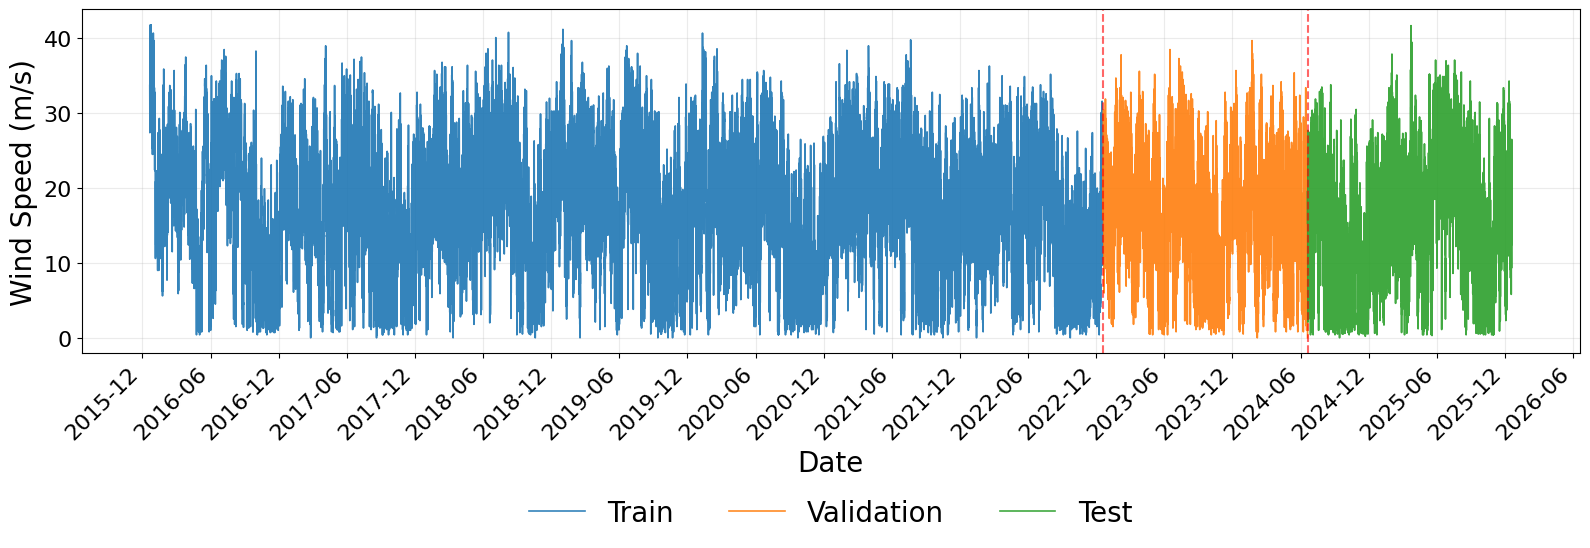


📊 Fonseca:


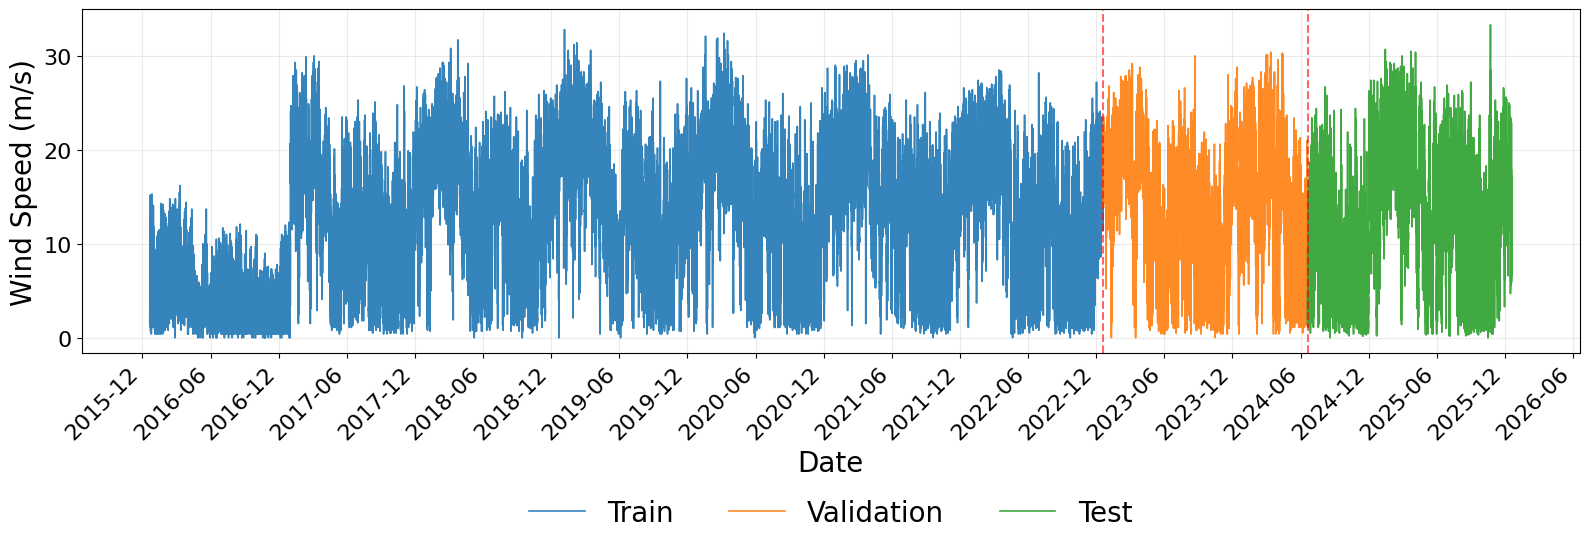


📊 Maicao:


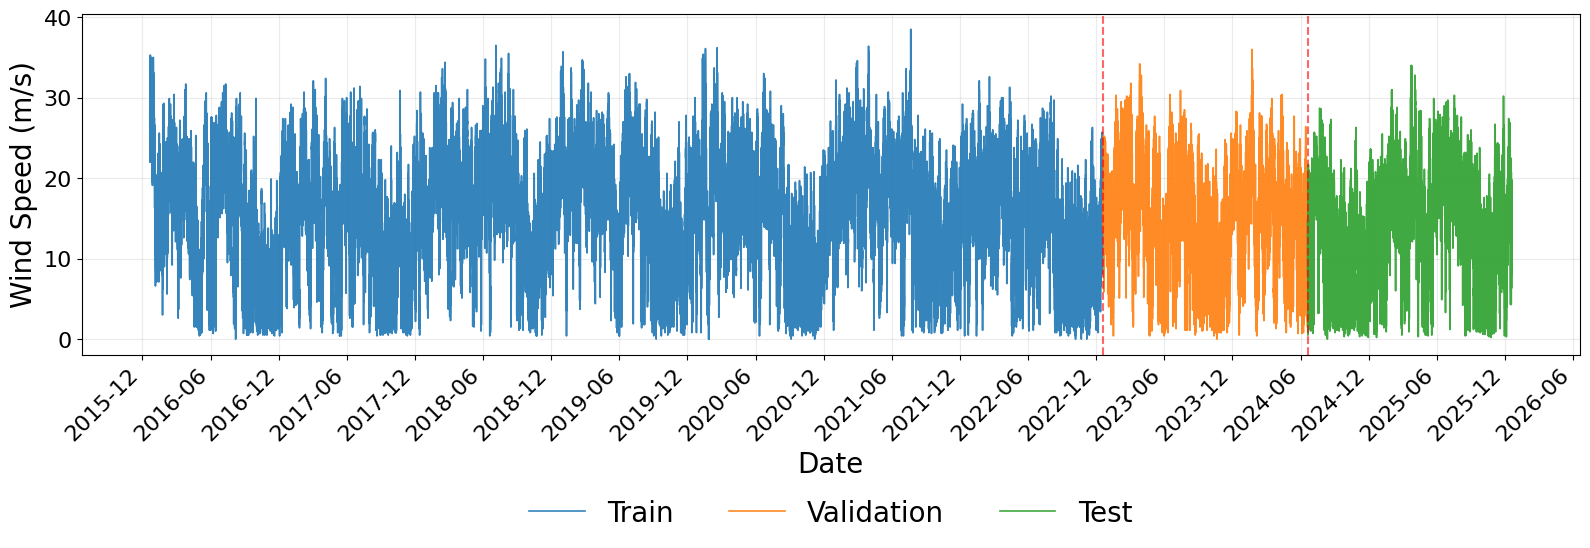


📊 Hatonuevo:


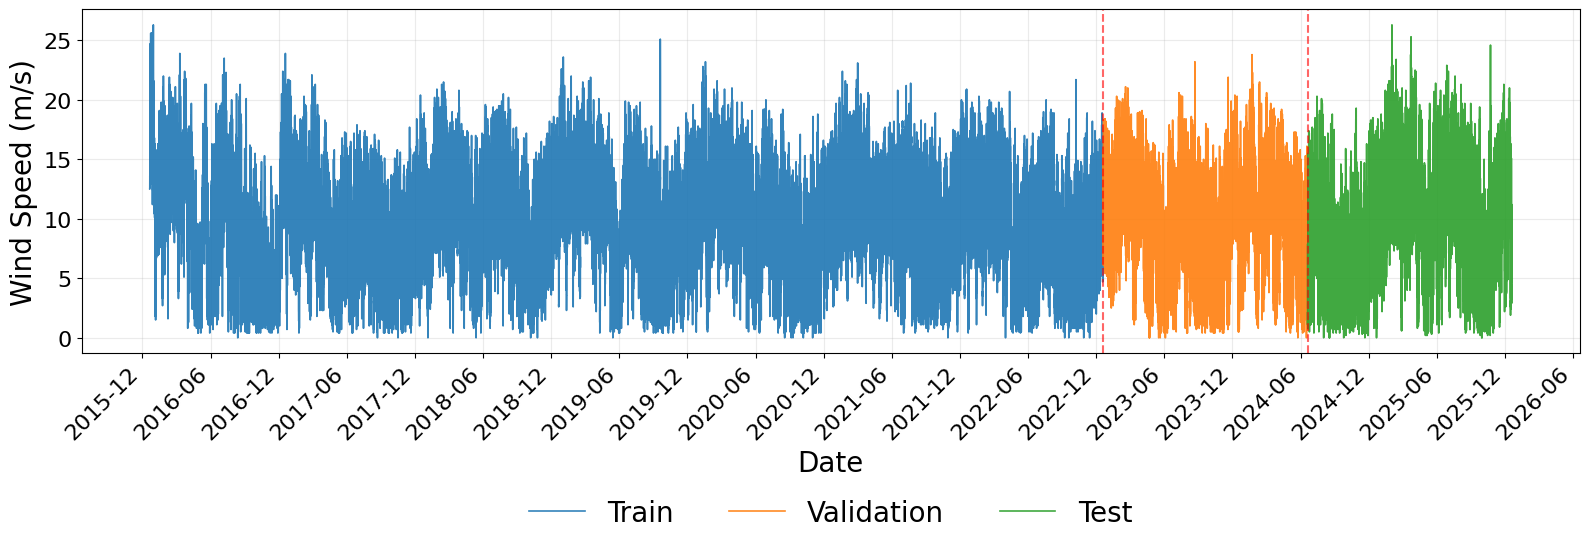


📊 La Jagua del Pilar:


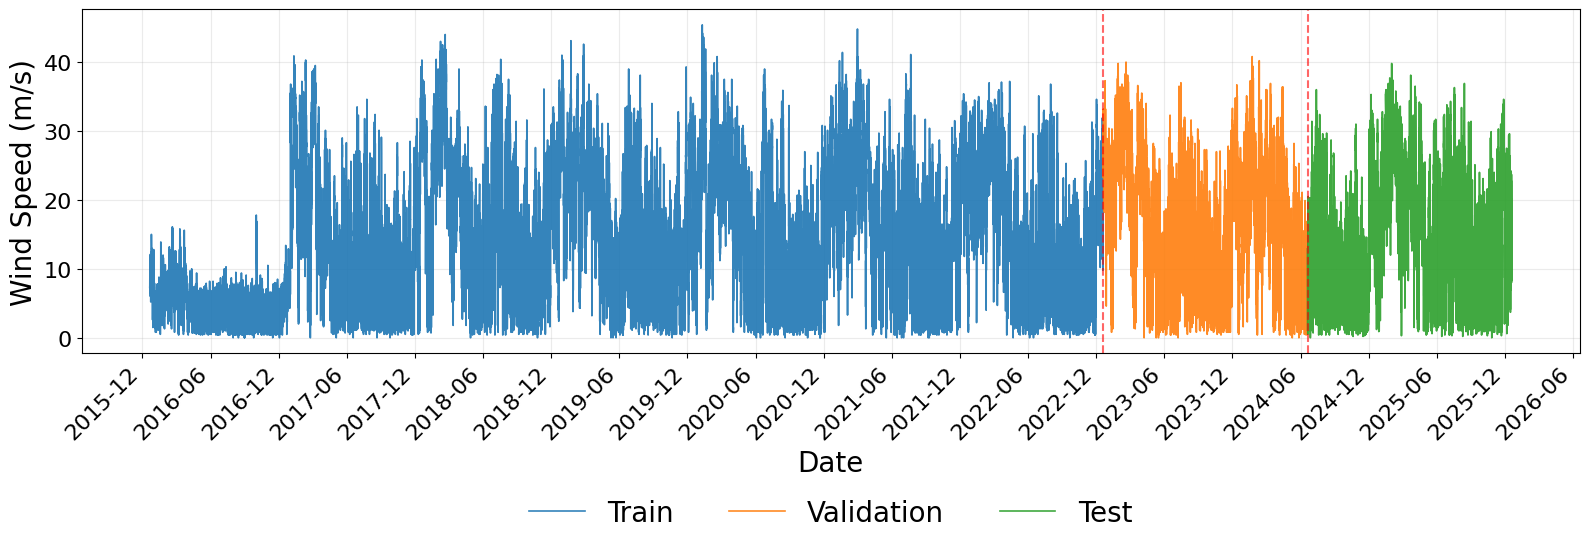


📊 El Molino:


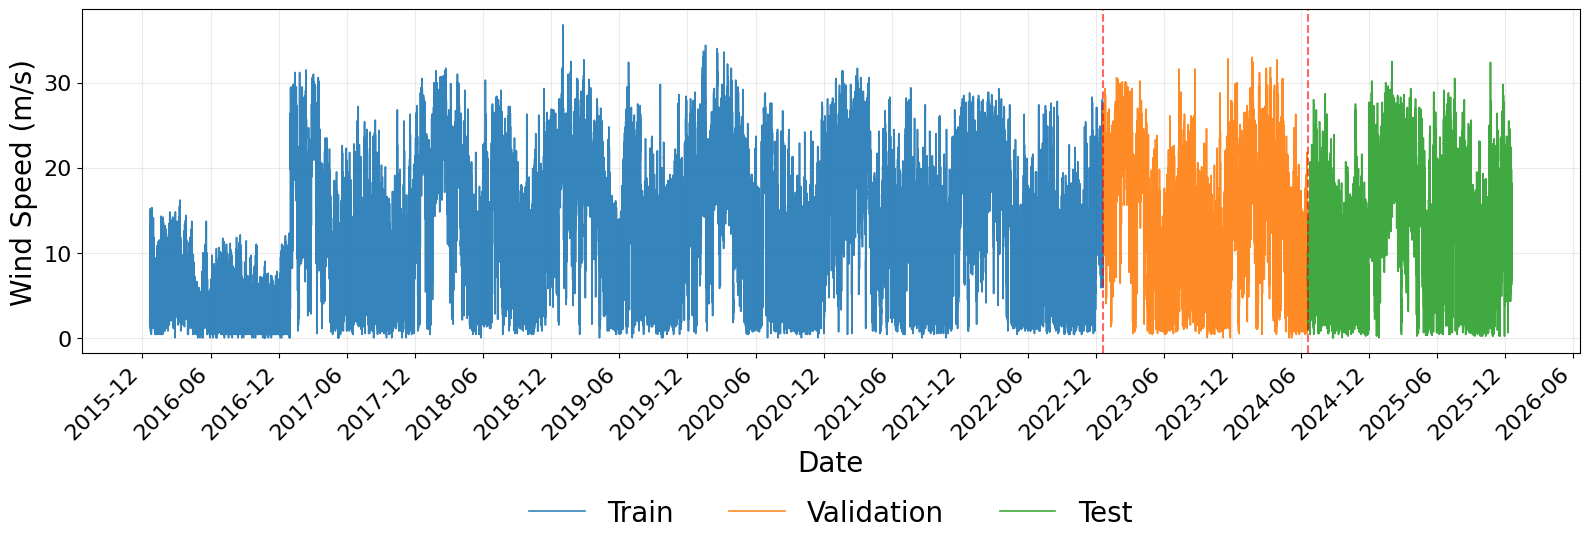


📊 San Juan del Cesar:


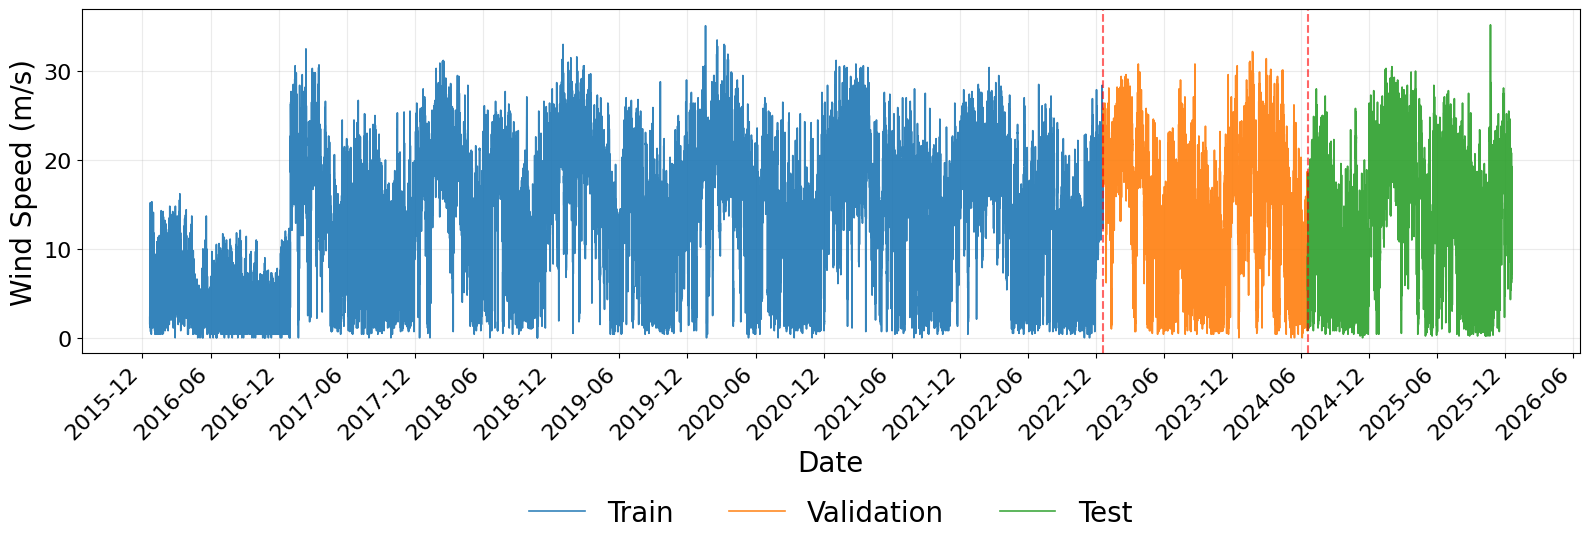


📊 Distraccion:


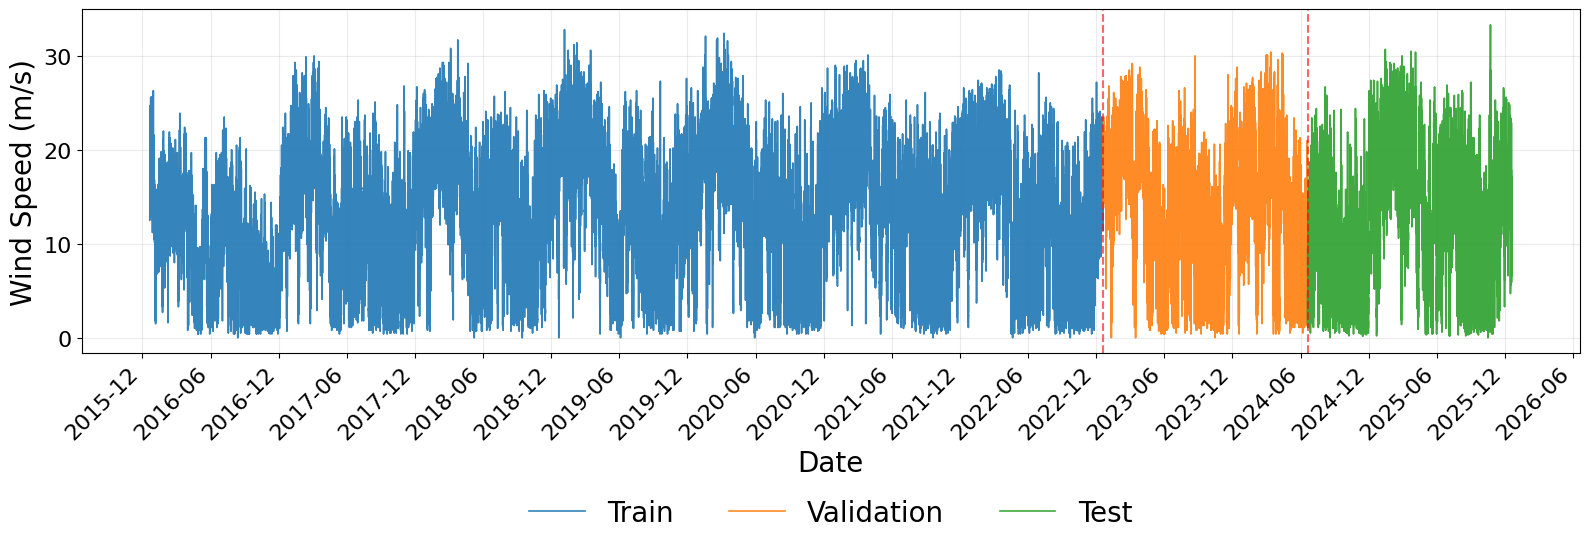


📊 Barrancas:


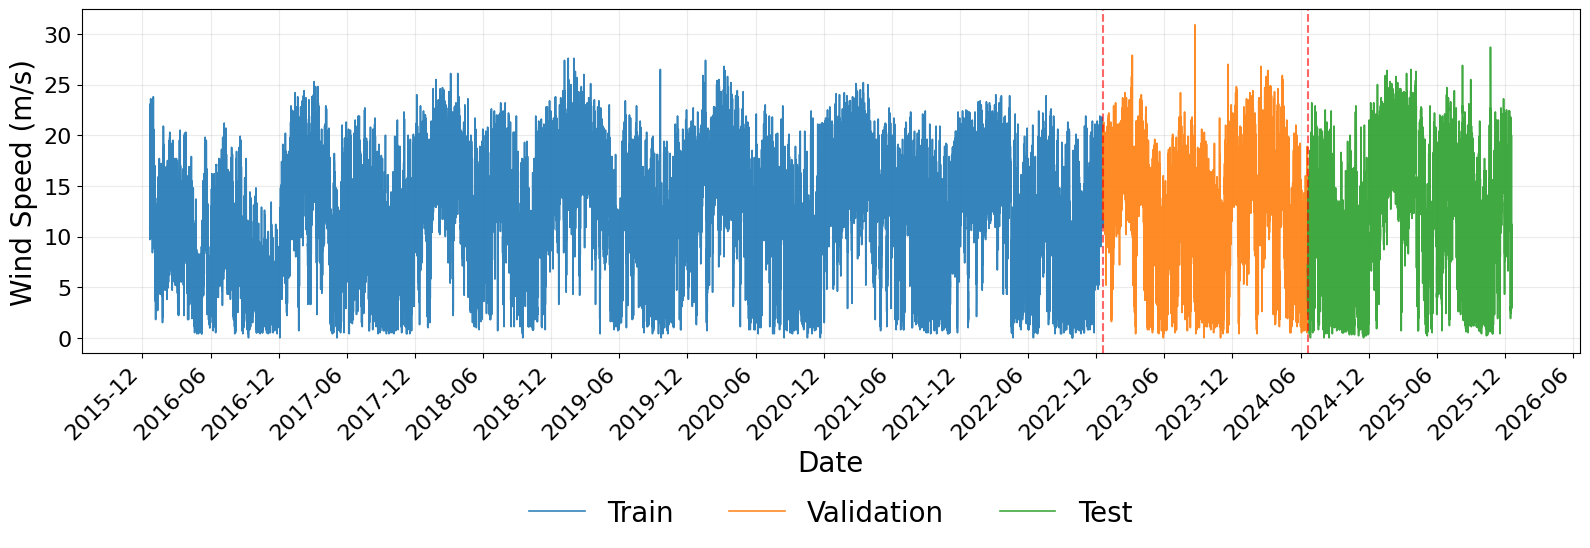


📊 Manaure:


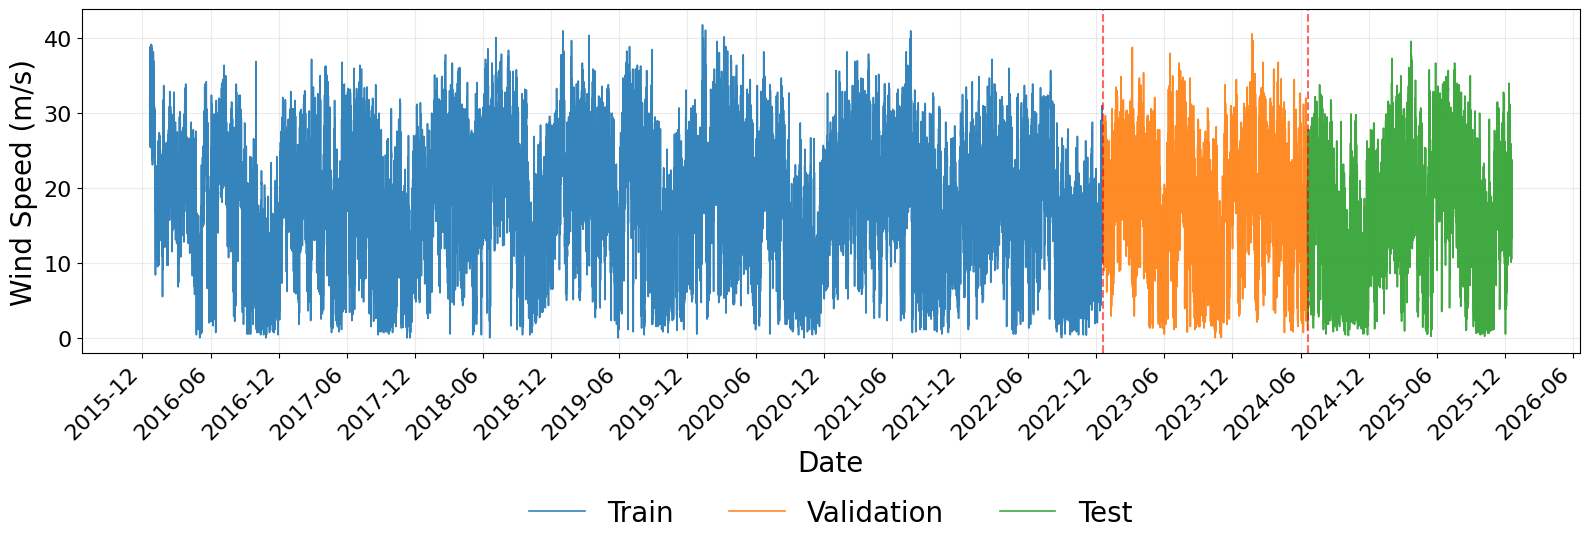


📊 Mingueo:


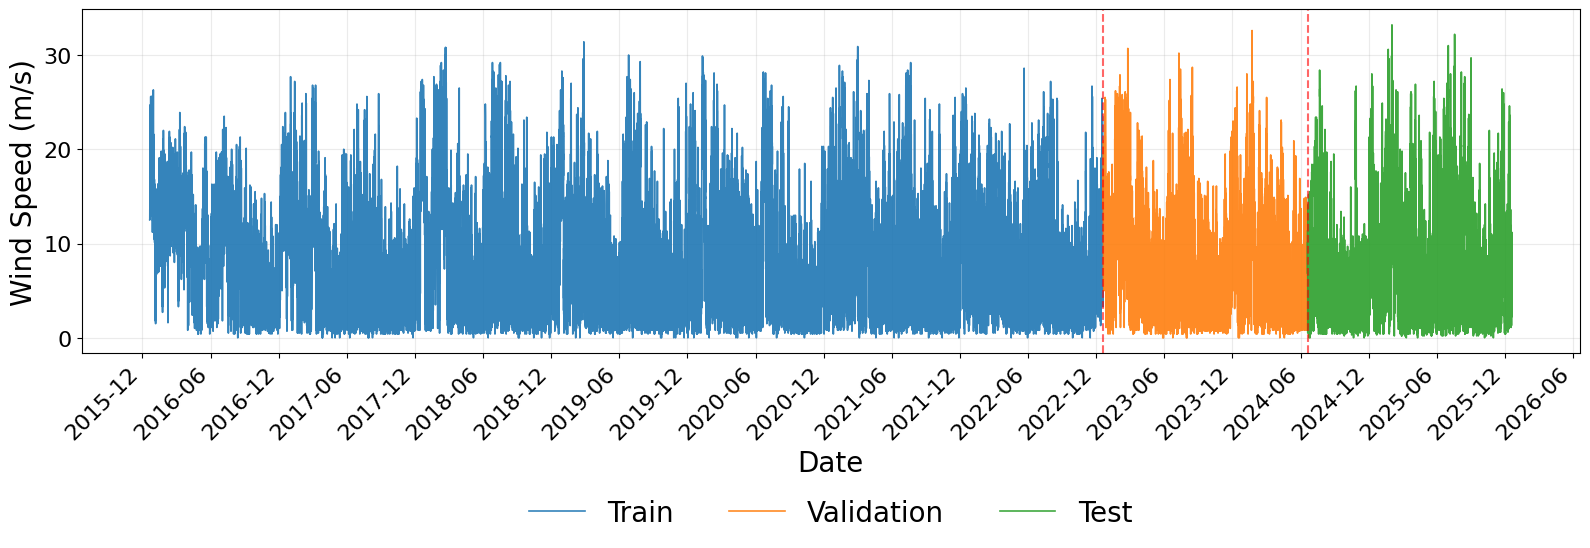


📊 Riohacha:


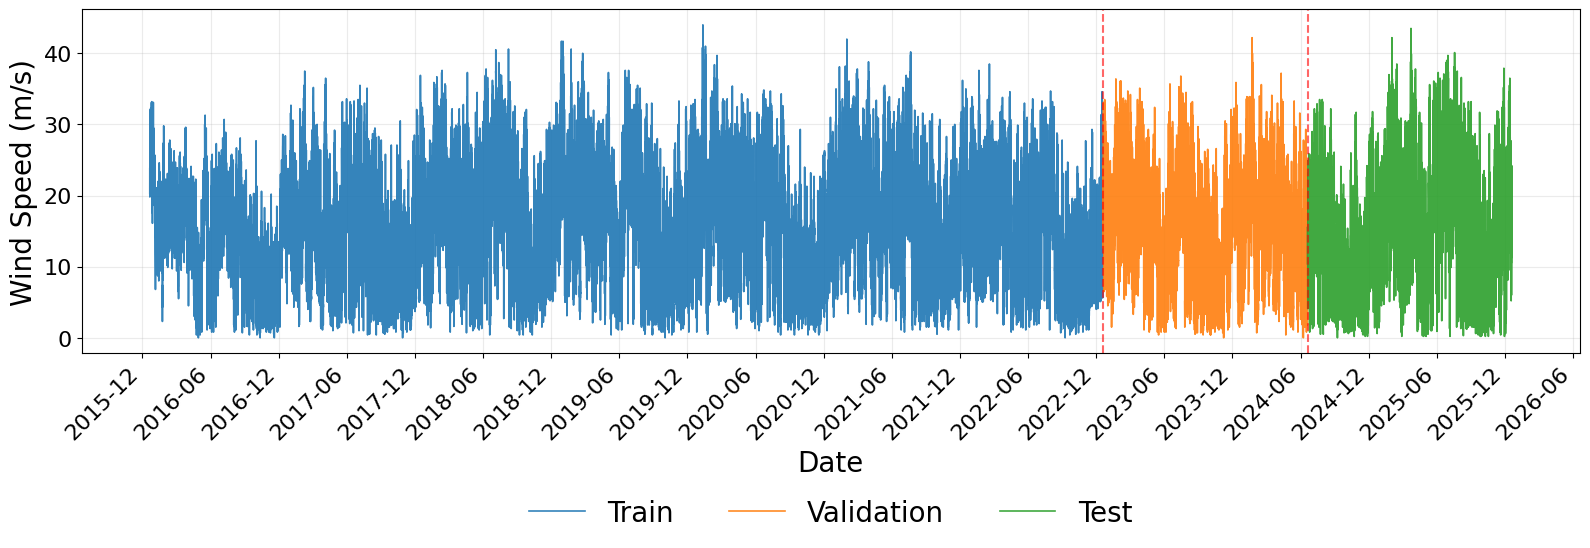


📊 Albania:


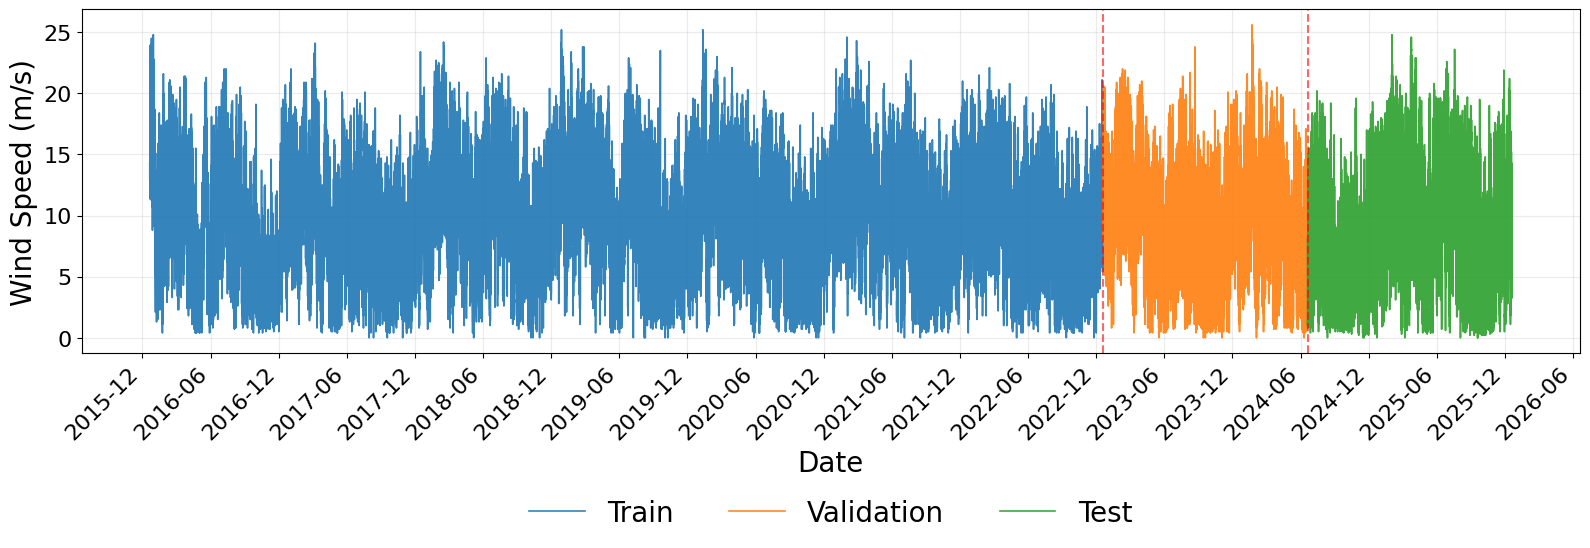

In [11]:
# Initialize dictionary and parameters
data_dict_loaded = {}

for file, df in _data_.items():
    name = file.split('.')[0].replace('_', ' ').title()
    name = re.sub(r'Del', 'del', name)
    
    # Get original data (for plotting)
    y_original = df['wind_speed_10m'].values
    dates = pd.to_datetime(df['datetime'])
    n_samples = len(y_original)
    
    # Calculate split indices
    i_tr = int(n_samples * 0.7)
    i_va = int(n_samples * 0.85)
    i_te = n_samples
    
    # ========================================
    # VISUALIZE with ORIGINAL data (no normalization)
    # ========================================
    print(f"\n📊 {name}:")
    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.plot(dates[:i_tr], y_original[:i_tr], 
            color='tab:blue', linewidth=1.2, label='Train', alpha=0.9)
    ax.plot(dates[i_tr:i_va], y_original[i_tr:i_va], 
            color='tab:orange', linewidth=1.2, label='Validation', alpha=0.9)
    ax.plot(dates[i_va:i_te], y_original[i_va:i_te], 
            color='tab:green', linewidth=1.2, label='Test', alpha=0.9)
    
    ax.axvline(x=dates[i_tr], color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    ax.axvline(x=dates[i_va], color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    ax.set_xlabel('Date', fontsize=20)
    ax.set_ylabel('Wind Speed (m/s)', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    
    plt.xticks(rotation=45, ha='right')
    
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.35),
        ncol=3,
        fontsize=20,
        frameon=False
    )
    
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # NORMALIZE data (Min-Max scaling to [0, 1])
    # ========================================
    y_min = y_original.min()
    y_max = y_original.max()
    y_normalized = (y_original - y_min) / (y_max - y_min)
    
    # ========================================
    # Build X and Y with NORMALIZED data
    # ========================================
    wind_data_normalized = y_normalized.reshape(-1, 1)
    X, Y = build_data(wind_data_normalized, x_len=x_len, y_len=y_len, gap=gap)
    
    # Store in dictionary
    data_dict_loaded[name] = {
        'X': X,                                 # Normalized input sequences
        'Y': Y,                                 # Normalized target sequences
        'time_series': y_original,              # Original time series
        'time_series_normalized': y_normalized, # Normalized time series
        'Max': y_max,                           # Max for denormalization
        'Min': y_min,                           # Min for denormalization
        'dates': dates.values,
    }
    


# **Load to PyTorch**

In [12]:
data = {}

for folder_name in  data_dict_loaded.keys():
    print(f"\nFolder: {folder_name}")

    # Inicializar sección
    data[folder_name] = {}

    X = data_dict_loaded[f"{folder_name}"]['X']
    Y = data_dict_loaded[f"{folder_name}"]['Y']
    Y = Y.squeeze(-1)

    print(X.shape, Y.shape)

    # Train/Validation/Test splits
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    if folder_name == "Etiopia-April" or folder_name == "Etiopia-May":
        batch_size = 64
    else:
        batch_size = 256

    train_loader = make_loader(X_train, y_train, batch_size)
    valid_loader = make_loader(X_valid, y_valid, batch_size)
    test_loader  = make_loader(X_test,  y_test, batch_size)

    data[folder_name] = {"loaders": {"train": train_loader, "valid": valid_loader, "test":  test_loader}}
    


Folder: Uribia
(87551, 48, 1) (87551, 24)

Folder: Fonseca
(87551, 48, 1) (87551, 24)

Folder: Maicao
(87551, 48, 1) (87551, 24)

Folder: Hatonuevo
(87551, 48, 1) (87551, 24)

Folder: La Jagua del Pilar
(87551, 48, 1) (87551, 24)

Folder: El Molino
(87551, 48, 1) (87551, 24)

Folder: San Juan del Cesar
(87551, 48, 1) (87551, 24)

Folder: Distraccion
(87551, 48, 1) (87551, 24)

Folder: Barrancas
(87551, 48, 1) (87551, 24)

Folder: Manaure
(87551, 48, 1) (87551, 24)

Folder: Mingueo
(87551, 48, 1) (87551, 24)

Folder: Riohacha
(87551, 48, 1) (87551, 24)

Folder: Albania
(87551, 48, 1) (87551, 24)


In [13]:
batch = next(iter(data[folder_name]["loaders"]["train"]))
if isinstance(batch, (list, tuple)):
    _, y_sample = batch
else:
    y_sample = batch["y"]
H = y_sample.shape[1]
print(f"Usando dataset: {folder_name} | Horizonte H={H}")

Usando dataset: Albania | Horizonte H=24


# **Model RFF+RNN**

In [14]:
class DenseRFF_PT(nn.Module):
    """
    Implementación de Random Fourier Features (RFF)
    - Compatible con kernel gaussiano o laplaciano.
    - Proyección: Φ(x) = sqrt(2/Nf) * cos(Wx + b)
    - Soporta parámetros entrenables para escala espectral.
    """
    def __init__(self, Nf, scale=None, gamma=None, normalization=True,
                 function="cos", trainable_scale=True, trainable_W=True,
                 seed=None, kernel='gaussian'):
        super().__init__()
        self.Nf = Nf
        self.gamma = gamma
        self.scale = scale
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.kernel_type = kernel

        # Inicialización diferida
        self.W = None
        self.b = None
        self.rho_scale = None
        self._eps = 1e-8
        self.bandwidth_history = []

    def _get_random_features_initializer(self, shape, sigma=1.0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        if self.kernel_type == 'gaussian':
            return np.random.randn(*shape) / sigma
        elif self.kernel_type == 'laplacian':
            return np.random.laplace(loc=0.0, scale=1.0, size=shape) / sigma
        else:
            raise ValueError(f'Unsupported initializer {self.kernel_type}')

    def _ensure_params_initialized(self, device, D):
        if self.W is None:
            if self.gamma is not None:
                sigma = np.sqrt(1.0 / (2 * self.gamma))
            else:
                sigma = 1.0
            if self.scale is None:
                self.scale = sigma

            W_init = self._get_random_features_initializer((D, self.Nf),
                                                           sigma=self.scale,
                                                           seed=self.seed)
            self.W = nn.Parameter(torch.tensor(W_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)

            b_init = np.random.uniform(0.0, 2 * np.pi, size=(self.Nf,))
            self.b = nn.Parameter(torch.tensor(b_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)

            init_kernel_scale = 1.0
            rho0 = np.log(np.exp(init_kernel_scale) - 1.0)
            self.rho_scale = nn.Parameter(
                torch.tensor([rho0], dtype=torch.float32, device=device),
                requires_grad=self.trainable_scale
            )

    def _kernel_scale(self):
        return F.softplus(self.rho_scale) + self._eps

    def bandwidth_lengthscale(self):
        if self.rho_scale is None or self.scale is None:
            return None
        ks = float(self._kernel_scale().detach().cpu().item())
        return float(self.scale) / ks

    @torch.no_grad()
    def log_bandwidth(self, step):
        ell = self.bandwidth_lengthscale()
        if ell is not None:
            self.bandwidth_history.append((step, float(ell)))

    def forward(self, inputs):
        device = inputs.device
        if inputs.dim() == 2:
            inputs = inputs.unsqueeze(1)
        elif inputs.dim() != 3:
            raise ValueError(f"Expected [B,T,D], got {inputs.shape}")

        B, T, D = inputs.shape
        self._ensure_params_initialized(device, D)
        kernel_scale = self._kernel_scale()

        proj = torch.matmul(inputs, self.W * kernel_scale) + self.b
        outputs = torch.cos(proj) * np.sqrt(2.0 / self.Nf)

        if self.normalization:
            norm = np.sqrt(self.Nf)
            outputs = outputs / norm

        return outputs.permute(0, 2, 1)  # [B, Nf, T]

In [15]:
class SpectralDropout1d(nn.Module):
    def __init__(self, p: float = 0.1, channels_last: bool = True):
        super().__init__()
        self.p = p
        self.channels_last = channels_last
    def forward(self, x):
        if (not self.training) or self.p == 0.0:
            return x
        if self.channels_last:
            B, T, F = x.shape
            mask = (torch.rand(B, 1, F, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask
        else:
            B, F, T = x.shape
            mask = (torch.rand(B, F, 1, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask

In [16]:
class TemporalSpectralBlock(nn.Module):
    """
    Bloque temporal convolucional dilatado con residual y normalización.
    Garantiza longitudes compatibles mediante recorte dinámico.
    """
    def __init__(self, features, kernel_size=3, dilation=2, p_drop=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=1)
        self.norm = nn.LayerNorm(features)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):  # [B,T,F]
        res = x
        y = x.transpose(1, 2)          # [B,F,T]
        y = self.act(self.conv1(y))
        y = self.conv2(y).transpose(1, 2)  # [B,T',F]
        # Ajuste de longitud si hay diferencia
        if y.size(1) != res.size(1):
            min_len = min(y.size(1), res.size(1))
            y = y[:, :min_len, :]
            res = res[:, :min_len, :]
        y = self.norm(y + res)
        y = self.act(y)
        return self.drop(y)

In [17]:
class MultiBandRFFEncoder(nn.Module):
    """
    Aplica DenseRFF_PT sobre múltiples bandas de escala y concatena las salidas.
    Entrada: [B, T, D]
    Salida: [B, T, F_total]
    """
    def __init__(self, in_dim=1, bands=(4., 24., 168.), nf_per_band=32,
                 kernel="gaussian", spectral_dropout_p=0.1):
        super().__init__()
        self.bands = nn.ModuleList([
            DenseRFF_PT(Nf=nf_per_band, function="cos",
                        trainable_W=True, trainable_scale=True,
                        kernel=kernel, scale=band)
            for band in bands
        ])
        self.out_dim = nf_per_band * len(self.bands)
        self.norm = nn.LayerNorm(self.out_dim)
        self.spec_do = SpectralDropout1d(p=spectral_dropout_p, channels_last=True)
        self.drop = nn.Dropout(spectral_dropout_p)

    def forward(self, x):
        outs = []
        for b in self.bands:
            z = b(x)                    # [B, Nf, T]
            z = z.transpose(1, 2)       # [B, T, Nf]
            outs.append(z)
        zcat = torch.cat(outs, dim=2)   # [B, T, F_total]
        zcat = self.norm(zcat)
        zcat = self.drop(self.spec_do(zcat))
        return zcat

In [18]:
class TemporalHead(nn.Module):
    """Pooling temporal + proyección final."""
    def __init__(self, hidden, horizon, pool="last"):
        super().__init__()
        self.pool = pool
        self.fc1 = nn.Linear(hidden, hidden // 2)
        self.fc2 = nn.Linear(hidden // 2, horizon)
        self.act = nn.ReLU()

    def forward(self, H):
        if self.pool == "mean":
            v = H.mean(dim=1)
        else:
            v = H[:, -1, :]
        return self.fc2(self.act(self.fc1(v)))

In [19]:
class RFF_AnyRNN_Forecaster(nn.Module):
    """
    Arquitectura general con codificación RFF + bloque temporal + RNN/GRU/LSTM.
    """
    def __init__(self, horizon=24, rnn_type="RNN",
                 bands=(4., 24., 168.), nf_per_band=64,
                 hidden=96, num_layers=1, bidirectional=False,
                 use_tsb=True, kernel="gaussian",
                 spectral_dropout_p=0.1, pool="last"):
        super().__init__()
        # --- Codificador espectral ---
        self.enc = MultiBandRFFEncoder(1, bands, nf_per_band, kernel, spectral_dropout_p)
        # --- Bloque temporal convolucional ---
        self.tsb = TemporalSpectralBlock(self.enc.out_dim) if use_tsb else nn.Identity()
        # --- RNN parametrizable ---
        self.rnn = getattr(nn, rnn_type)(
            input_size=self.enc.out_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        # --- Proyección final ---
        out_hidden = hidden * (2 if bidirectional else 1)
        self.head = TemporalHead(out_hidden, horizon, pool)

    def forward(self, x):
        z = self.enc(x)       # [B,T,F]
        z = self.tsb(z)       # [B,T,F]
        H, _ = self.rnn(z)    # [B,T,H]
        return self.head(H)   # [B,H]

# **Train**

In [20]:
class TotalLoss(nn.Module):
    def __init__(self, alpha_spec: float = 0.0, alpha_weight: float = 0.0):
        super().__init__()
        self.mse = nn.MSELoss()
        # alpha_* quedan ignorados en el baseline tradicional

    def forward(self, y_true, y_pred):
        # train_model llama criterion(yb, preds): (y_true, y_pred)
        return F.mse_loss(y_pred, y_true)

def ts_augment(x):
    return x

In [21]:
def train_model(model, data, folder_name, num_epochs=50, lr=1e-3, device="cuda", trial=None, lr_rho_multiplier: float = 1.0, log_per_batch: bool = False):
    """
    Versión mejorada con:
      ✅ Compatibilidad con nuevas clases (RecurrentRFFForecast, MultiScaleRFF)
      ✅ Data augmentation temporal (ts_augment)
      ✅ Pérdida combinada TotalLoss (Huber ponderado + Espectral)
      ✅ Logging automático de ℓ (bandwidth) si el modelo usa RFF
    """
    from collections import defaultdict
    import torch.optim as optim
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    loaders = data[folder_name]["loaders"]
    train_loader = loaders["train"]
    valid_loader = loaders["valid"]
    test_loader  = loaders["test"]

    # =============================================================
    # Helpers internos
    # =============================================================
    def _iter_rff_modules(m):
        """Detecta módulos tipo RFF (DenseRFF_PT o MultiScaleRFF)."""
        target_class_names = ["DenseRFF_PT", "MultiScaleRFF"]
        for sub in m.modules():
            name_ok = (sub.__class__.__name__ in target_class_names)
            has_attrs = any(hasattr(sub, a) for a in ["kernel_scale", "bandwidth_lengthscale", "log_bandwidth", "scale"])
            if name_ok or has_attrs:
                yield sub

    def _safe_item(x):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            try:
                return float(x)
            except Exception:
                return None

    def _compute_ell_if_possible(rff):
        """Intenta obtener una 'longitud de banda' interpretable."""
        if hasattr(rff, "bandwidth_lengthscale"):
            try:
                ell = rff.bandwidth_lengthscale()
                if isinstance(ell, (list, tuple)):
                    ell = ell[0]
                return _safe_item(ell)
            except Exception:
                pass

        try:
            scale = getattr(rff, "scale", None)
            ksc   = getattr(rff, "kernel_scale", None)
            if scale is not None and ksc is not None:
                scale = _safe_item(scale)
                ksc   = _safe_item(ksc)
                if scale is not None and ksc is not None and ksc != 0.0:
                    return scale / ksc
        except Exception:
            pass

        return None

    # =============================================================
    # Inicialización de modelo y optimizador
    # =============================================================
    xb0, yb0 = next(iter(train_loader))
    window  = int(xb0.shape[1])
    horizon = int(yb0.shape[1])

    if hasattr(model, "fc2") and isinstance(model.fc2, nn.Linear) and model.fc2.out_features != horizon:
        model.fc2 = nn.Linear(model.fc2.in_features, horizon).to(device)

    model = model.to(device)

    with torch.no_grad():
        _ = model(xb0.to(device))

    named = list(model.named_parameters())
    rho_params   = [p for n, p in named if "rho_scale" in n and p.requires_grad]
    other_params = [p for n, p in named if "rho_scale" not in n and p.requires_grad]

    if lr_rho_multiplier != 1.0 and len(rho_params) > 0:
        optimizer = optim.Adam(
            [{"params": rho_params, "lr": lr * lr_rho_multiplier},
             {"params": other_params, "lr": lr}]
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # ✅ Pérdida híbrida
    criterion = TotalLoss(alpha_spec=1e-3, alpha_weight=0.05)

    best_val = float("inf")
    history = {"train_loss": [], "valid_loss": []}

    # Detectar RFFs una sola vez (tras warm-up)
    rff_modules = list(_iter_rff_modules(model))
    has_rff = len(rff_modules) > 0
    ell_series = defaultdict(list)
    rff_names = {id(m): f"RFF_{i+1}_{m.__class__.__name__}" for i, m in enumerate(rff_modules)}

    def _log_bandwidths(step):
        """Calcula y guarda ℓ por cada capa RFF si es posible."""
        for m in rff_modules:
            ell = _compute_ell_if_possible(m)
            if ell is not None and np.isfinite(ell):
                ell_series[rff_names[id(m)]].append((step, float(ell)))
            if hasattr(m, "log_bandwidth"):
                try:
                    m.log_bandwidth(step=step)
                except Exception:
                    pass

    # =============================================================
    # Loop de entrenamiento
    # =============================================================
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
            xb, yb = xb.to(device), yb.to(device)

            # 🔹 Augmentación temporal
            xb = ts_augment(xb)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(yb, preds)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

            if log_per_batch and has_rff:
                global_step = (epoch - 1) * len(train_loader) + batch_idx
                _log_bandwidths(step=global_step)

        train_loss /= len(train_loader.dataset)

        # -------- Validación --------
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(yb, preds)
                valid_loss += loss.item() * xb.size(0)
        valid_loss /= len(valid_loader.dataset)

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)

        if has_rff and not log_per_batch:
            _log_bandwidths(step=epoch)

        if epoch % 10 == 0:
            msg = f"Epoch {epoch:03d} | Train {train_loss:.4f} | Valid {valid_loss:.4f}"
            if has_rff:
                name0 = next(iter(rff_names.values()))
                last_series = ell_series.get(name0, [])
                if last_series:
                    msg += f" | ℓ={last_series[-1][1]:.4f}"
            print(msg)

        if valid_loss < best_val:
            best_val = valid_loss
            torch.save(model.state_dict(), f"best_model_{folder_name}.pth")

        if (trial is not None) and ("optuna" in globals()):
            trial.report(-valid_loss, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # =============================================================
    # Test y métricas
    # =============================================================
    model.load_state_dict(torch.load(f"best_model_{folder_name}.pth", map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true.append(yb.cpu())
            y_pred.append(preds.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # --- Global ---
    r2   = float(r2_score(y_true, y_pred))
    mae  = float(mean_absolute_error(y_true, y_pred))
    mse  = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    print(f"Test GLOBAL | R2={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")

    # --- Por horizonte ---
    H = y_true.shape[1]
    metrics_pointwise = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(H):
        yt = y_true[:, h]
        yp = y_pred[:, h]
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_pointwise["horizon"].append(h+1)
        metrics_pointwise["RMSE"].append(float(rmse_h))
        metrics_pointwise["MAE"].append(float(mae_h))
        metrics_pointwise["R2"].append(float(r2_h))
    df_pointwise = pd.DataFrame(metrics_pointwise)

    # --- Acumuladas ---
    metrics_cumulative = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(1, H+1):
        yt = y_true[:, :h].reshape(-1)
        yp = y_pred[:, :h].reshape(-1)
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_cumulative["horizon"].append(h)
        metrics_cumulative["RMSE"].append(float(rmse_h))
        metrics_cumulative["MAE"].append(float(mae_h))
        metrics_cumulative["R2"].append(float(r2_h))
    df_cumulative = pd.DataFrame(metrics_cumulative)

    # --- Logging de bandwidth ---
    """
    if has_rff and any(len(v) > 0 for v in ell_series.values()):
        x_label = "Step" if log_per_batch else "Epoch"
        for name, series in ell_series.items():
            if not series:
                continue
            steps, ells = zip(*series)
            plt.figure()
            plt.plot(steps, ells, marker="o")
            plt.xlabel(x_label)
            plt.ylabel("Bandwidth ℓ (aprox.)")
            plt.title(f"Evolución del ancho de banda — {name}")
            plt.tight_layout()
            out_fig = f"bandwidth_evolution_{folder_name}_{name}.png"
            plt.savefig(out_fig, dpi=150)
            print(f"[OK] Guardado: {out_fig}")

    # --- Bandwidth logging: unified plot for all RFF layers ---
    if has_rff and any(len(v) > 0 for v in ell_series.values()):

        x_label = "Step" if log_per_batch else "Epoch"

        plt.figure(figsize=(10, 5))

        for module in rff_modules:
            key = rff_names[id(module)]
            series = ell_series[key]
            if not series:
                continue

            steps, ells = zip(*series)

            clean_name = key.replace(".", " → ")

            # --- Read actual mapping dimension ---
            Nf_value = getattr(module, "Nf", "?")

            legend_label = f"{clean_name} (Nf={Nf_value})"

            plt.plot(
                steps,
                ells,
                marker="o",
                linewidth=2,
                markersize=4,
                alpha=0.85,
                label=legend_label
            )

        plt.xlabel(x_label)
        plt.ylabel("Bandwidth ℓ (approx.)")
        plt.title(f"Bandwidth Evolution Across All RFF Layers\nDataset: {folder_name}")
        plt.legend(title="RFF Layers", loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        out_fig = f"bandwidth_evolution_ALL_RFF_{folder_name}.png"
        plt.savefig(out_fig, dpi=150)
        plt.close()

        print(f"[OK] Saved unified bandwidth plot: {out_fig}")
        """
    # --- ---
    if has_rff and any(len(v) > 0 for v in ell_series.values()):

        x_label = "Step" if log_per_batch else "Epoch"

        # --- Square figure ---
        fig, ax1 = plt.subplots(figsize=(10, 7))

        # Additional y-axes
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("axes", 1.18))  # shift right

        # Colors
        color_small  = "tab:blue"
        color_medium = "tab:green"
        color_large  = "tab:red"

        # ============================================================
        # Classify layers into small/medium/large ℓ groups
        # ============================================================
        avg_ells = [np.mean([v for _, v in s]) for s in ell_series.values() if len(s) > 0]
        p33, p66 = np.percentile(avg_ells, [33, 66])

        groups = {"small": [], "medium": [], "large": []}

        for module in rff_modules:
            key = rff_names[id(module)]
            series = ell_series[key]
            if not series:
                continue

            steps, ells = zip(*series)
            ells = np.array(ells)
            mean_ell = float(np.mean(ells))
            Nf_value = getattr(module, "Nf", "?")

            if mean_ell < p33:
                groups["small"].append((key, steps, ells, Nf_value))
            elif mean_ell < p66:
                groups["medium"].append((key, steps, ells, Nf_value))
            else:
                groups["large"].append((key, steps, ells, Nf_value))

        # ============================================================
        # Plot SMALL scale ℓ — ax1
        # ============================================================
        # Extract Nf for label (median Nf in this group)
        small_Nf = np.median([g[3] for g in groups["small"]]) if groups["small"] else "?"

        for key, steps, ells, Nf_value in groups["small"]:
            ax1.plot(
                steps, ells,
                marker="o", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_small, alpha=0.92
            )

        ax1.set_xlabel(x_label, fontsize=18)
        ax1.set_ylabel(f"$\mathbf{{\\varphi}}$ (small scale) — Nf={small_Nf}", color=color_small, fontsize=18)
        ax1.tick_params(axis="x", labelsize=16)
        ax1.tick_params(axis="y", labelcolor=color_small, labelsize=16)
        ax1.grid(True, linestyle="--", alpha=0.35)

        # ============================================================
        # Plot MEDIUM scale ℓ — ax2
        # ============================================================
        medium_Nf = np.median([g[3] for g in groups["medium"]]) if groups["medium"] else "?"

        for key, steps, ells, Nf_value in groups["medium"]:
            ax2.plot(
                steps, ells,
                marker="s", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_medium, alpha=0.92
            )

        #ax2.set_ylabel(f"\varphi (medium scale) — Nf={medium_Nf}",
        #              color=color_medium, fontsize=18)
        ax2.set_ylabel(f"$\mathbf{{\\varphi}}$ (medium scale) — Nf={small_Nf}",
                      color=color_medium, fontsize=18)

        ax2.tick_params(axis="y", labelcolor=color_medium, labelsize=16)

        # ============================================================
        # Plot LARGE scale ℓ — ax3
        # ============================================================
        large_Nf = np.median([g[3] for g in groups["large"]]) if groups["large"] else "?"

        for key, steps, ells, Nf_value in groups["large"]:
            ax3.plot(
                steps, ells,
                marker="^", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_large, alpha=0.92
            )

        ax3.set_ylabel(f"$\mathbf{{\\varphi}}$ (large scale) — Nf={large_Nf}",
                      color=color_large, fontsize=18)
        ax3.tick_params(axis="y", labelcolor=color_large, labelsize=16)

        # ============================================================
        # Unified Legend (all layers + Nf)
        # ============================================================
        handles, labels = [], []
        for ax in [ax1, ax2, ax3]:
            h, l = ax.get_legend_handles_labels()
            handles += h
            labels  += l

        fig.legend(
            handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.08),
            ncol=2,
            fontsize=15,
            title="RFF Layers (with Nf mapping dimension)"
        )

        plt.tight_layout(rect=[0, 0, 1, 0.92])

        out_fig = f"bandwidth_{folder_name}.png"
        plt.savefig(out_fig, dpi=240)
        plt.close()

        print(f"[OK] Saved triple-axis plot with Nf in axes: {out_fig}")

    return history, df_pointwise, df_cumulative, y_true, y_pred

# **Hiperparametres tunnnig**

In [22]:
def build_model_from_trial(trial, horizon, rnn_type):
    # --- Hiperparámetros Optuna ---

    #kernel = trial.suggest_categorical("kernel", ["gaussian", "laplacian"])
    #use_tsb = trial.suggest_categorical("use_tsb", [True, False])
    #bidir   = trial.suggest_categorical("bidirectional", [False, True])

    # Multibanda
    # Puedes fijar bandas típicas o permitir elección:
    bands_preset = trial.suggest_categorical("bands_preset", ["4-24-168", "6-24-72", "12-24-168"])
    if bands_preset == "4-24-168":
        bands = (4., 24., 168.)
    elif bands_preset == "6-24-72":
        bands = (6., 24., 72.)
    else:
        bands = (12., 24., 168.)

    nf_per_band = trial.suggest_int("nf_per_band", 16, 128, step=8)
    hidden      = trial.suggest_int("hidden", 16, 256, step=16)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    spec_do_p   = trial.suggest_float("spectral_dropout_p", 0.0, 0.5, step=0.1)
    #pool        = trial.suggest_categorical("pool", ["last", "mean"])

    model = RFF_AnyRNN_Forecaster(
        horizon=horizon,
        rnn_type=rnn_type,
        bands=bands,
        nf_per_band=nf_per_band,
        hidden=hidden,
        num_layers=num_layers,
        bidirectional=False,
        use_tsb=True,
        kernel="gaussian",
        spectral_dropout_p=spec_do_p,
        pool="last"
    )
    return model

In [23]:
def objective_factory(data, folder_name, device, rnn_type):
    def objective(trial):

        # ---- Optimizador
        #lr   = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        lr_rho_multiplier = trial.suggest_float("lr_rho_multiplier", 0.5, 5.0, log=True)
        #num_epochs = trial.suggest_int("num_epochs", 15, 60, step=5)  # puedes ampliar

        # Detectar horizonte desde loaders
        xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
        horizon = int(yb0.shape[1])

        model = build_model_from_trial(trial, horizon, rnn_type).to(device)

        # Entrenar y obtener historia
        history, df_point, df_cum, y_true, y_pred = train_model(
            model=model,
            data=data,
            folder_name=folder_name,
            num_epochs=10,
            lr=1e-3,
            device=device,
            trial=trial,
            lr_rho_multiplier=lr_rho_multiplier,
            log_per_batch=False
        )
        # Usar la MEJOR pérdida de validación observada
        best_valid = float(min(history["valid_loss"])) if history["valid_loss"] else float("inf")

        # (Opcional) reportar también una métrica secundaria para diagnóstico
        trial.set_user_attr("last_valid", history["valid_loss"][-1] if history["valid_loss"] else None)

        return best_valid
    return objective

In [24]:
# Configure sampler and pruner
sampler = optuna.samplers.TPESampler(seed=42)
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=5)

# Dictionary to store all studies
all_studies = {}

# 🔄 LOOP OVER ALL DATASETS
for folder_name in list(data_dict_loaded.keys()):
    
    print(f"\n{'='*80}")
    print(f"📊 DATASET: {folder_name}")
    print(f"{'='*80}")
    
    # Create storage URL for this dataset
    storage_url = f"sqlite:///optuna_results_{folder_name.replace(' ', '_')}.db"

    # Initialize studies dictionary for this dataset
    studies = {}
    
    # 🎯 ONLY LSTM (not RNN or GRU)
    rnn_type = "LSTM"
    
    study_name = f"RFF-{rnn_type} Tuning-{folder_name}"
    print(f"\n🔧 Optuna Study: {study_name} \n")
    
    
    study = optuna.create_study(
        direction="minimize", 
        sampler=sampler, 
        pruner=pruner, 
        study_name=study_name,
        storage=storage_url, 
        load_if_exists=True
    )
    
    objective = objective_factory(data, folder_name, device, rnn_type)
    study.optimize(objective, n_trials=n_trials_per_type, gc_after_trial=True)
    
    print(f"\n✅ Results for {folder_name}:")
    print(f"   Best trial: {study.best_trial.number}")
    print(f"   Best valid MSE: {study.best_value:.6f}")
    print(f"   Best params: {study.best_trial.params}")
    
    studies[rnn_type] = study
    all_studies[folder_name] = studies



📊 DATASET: Uribia

🔧 Optuna Study: RFF-LSTM Tuning-Uribia 



[I 2025-12-19 16:50:44,904] A new study created in RDB with name: RFF-LSTM Tuning-Uribia


Epoch 010 | Train 0.0121 | Valid 0.0117 | ℓ=3.1523
Test GLOBAL | R2=0.6895 | MAE=0.0826 | RMSE=0.1076


[I 2025-12-19 16:51:11,359] Trial 0 finished with value: 0.01155617136661408 and parameters: {'lr_rho_multiplier': 1.184431975182039, 'bands_preset': '4-24-168', 'nf_per_band': 32, 'hidden': 48, 'num_layers': 1, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.01155617136661408.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Uribia.png
Epoch 010 | Train 0.0113 | Valid 0.0111 | ℓ=9.2115
Test GLOBAL | R2=0.7010 | MAE=0.0808 | RMSE=0.1056


[I 2025-12-19 16:52:18,752] Trial 1 finished with value: 0.011142213648341507 and parameters: {'lr_rho_multiplier': 1.995652939280839, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 64, 'num_layers': 1, 'spectral_dropout_p': 0.1}. Best is trial 1 with value: 0.011142213648341507.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Uribia.png
Epoch 010 | Train 0.0115 | Valid 0.0112 | ℓ=3.5787
Test GLOBAL | R2=0.6981 | MAE=0.0812 | RMSE=0.1061


[I 2025-12-19 16:53:10,789] Trial 2 finished with value: 0.011223019022964737 and parameters: {'lr_rho_multiplier': 1.0074238942079328, 'bands_preset': '4-24-168', 'nf_per_band': 88, 'hidden': 48, 'num_layers': 1, 'spectral_dropout_p': 0.2}. Best is trial 1 with value: 0.011142213648341507.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Uribia.png

✅ Results for Uribia:
   Best trial: 1
   Best valid MSE: 0.011142
   Best params: {'lr_rho_multiplier': 1.995652939280839, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 64, 'num_layers': 1, 'spectral_dropout_p': 0.1}

📊 DATASET: Fonseca

🔧 Optuna Study: RFF-LSTM Tuning-Fonseca 



[I 2025-12-19 16:53:11,223] A new study created in RDB with name: RFF-LSTM Tuning-Fonseca


Epoch 010 | Train 0.0162 | Valid 0.0157 | ℓ=3.4398
Test GLOBAL | R2=0.5921 | MAE=0.0987 | RMSE=0.1261


[I 2025-12-19 16:53:57,590] Trial 0 finished with value: 0.015673048363552818 and parameters: {'lr_rho_multiplier': 1.4290255329034678, 'bands_preset': '4-24-168', 'nf_per_band': 80, 'hidden': 16, 'num_layers': 2, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.015673048363552818.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Fonseca.png
Epoch 010 | Train 0.0141 | Valid 0.0138 | ℓ=5.3359
Test GLOBAL | R2=0.6445 | MAE=0.0904 | RMSE=0.1177


[I 2025-12-19 16:54:27,084] Trial 1 finished with value: 0.013715902654436028 and parameters: {'lr_rho_multiplier': 0.5807932994623226, 'bands_preset': '6-24-72', 'nf_per_band': 48, 'hidden': 32, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 1 with value: 0.013715902654436028.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Fonseca.png
Epoch 010 | Train 0.0139 | Valid 0.0137 | ℓ=10.9303
Test GLOBAL | R2=0.6472 | MAE=0.0895 | RMSE=0.1173


[I 2025-12-19 16:56:05,543] Trial 2 finished with value: 0.013610756868280593 and parameters: {'lr_rho_multiplier': 0.6622290670049675, 'bands_preset': '12-24-168', 'nf_per_band': 40, 'hidden': 176, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 2 with value: 0.013610756868280593.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Fonseca.png

✅ Results for Fonseca:
   Best trial: 2
   Best valid MSE: 0.013611
   Best params: {'lr_rho_multiplier': 0.6622290670049675, 'bands_preset': '12-24-168', 'nf_per_band': 40, 'hidden': 176, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}

📊 DATASET: Maicao

🔧 Optuna Study: RFF-LSTM Tuning-Maicao 



[I 2025-12-19 16:56:05,991] A new study created in RDB with name: RFF-LSTM Tuning-Maicao


Epoch 010 | Train 0.0106 | Valid 0.0105 | ℓ=4.4034
Test GLOBAL | R2=0.6706 | MAE=0.0791 | RMSE=0.1022


[I 2025-12-19 16:58:27,095] Trial 0 finished with value: 0.01053178938640774 and parameters: {'lr_rho_multiplier': 1.7606794027339339, 'bands_preset': '6-24-72', 'nf_per_band': 128, 'hidden': 240, 'num_layers': 2, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.01053178938640774.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Maicao.png
Epoch 010 | Train 0.0113 | Valid 0.0111 | ℓ=10.9870
Test GLOBAL | R2=0.6512 | MAE=0.0822 | RMSE=0.1052


[I 2025-12-19 16:59:14,739] Trial 1 finished with value: 0.011140872315338241 and parameters: {'lr_rho_multiplier': 0.6130028679593762, 'bands_preset': '12-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 0 with value: 0.01053178938640774.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Maicao.png
Epoch 010 | Train 0.0106 | Valid 0.0104 | ℓ=10.1784
Test GLOBAL | R2=0.6755 | MAE=0.0790 | RMSE=0.1015


[I 2025-12-19 17:00:55,914] Trial 2 finished with value: 0.010351351943656351 and parameters: {'lr_rho_multiplier': 0.9547826400522686, 'bands_preset': '12-24-168', 'nf_per_band': 24, 'hidden': 256, 'num_layers': 3, 'spectral_dropout_p': 0.1}. Best is trial 2 with value: 0.010351351943656351.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Maicao.png

✅ Results for Maicao:
   Best trial: 2
   Best valid MSE: 0.010351
   Best params: {'lr_rho_multiplier': 0.9547826400522686, 'bands_preset': '12-24-168', 'nf_per_band': 24, 'hidden': 256, 'num_layers': 3, 'spectral_dropout_p': 0.1}

📊 DATASET: Hatonuevo

🔧 Optuna Study: RFF-LSTM Tuning-Hatonuevo 



[I 2025-12-19 17:00:56,391] A new study created in RDB with name: RFF-LSTM Tuning-Hatonuevo


Epoch 010 | Train 0.0106 | Valid 0.0107 | ℓ=3.7699
Test GLOBAL | R2=0.6457 | MAE=0.0792 | RMSE=0.1030


[I 2025-12-19 17:01:56,928] Trial 0 finished with value: 0.010708696224531536 and parameters: {'lr_rho_multiplier': 0.506398162866574, 'bands_preset': '4-24-168', 'nf_per_band': 104, 'hidden': 32, 'num_layers': 2, 'spectral_dropout_p': 0.0}. Best is trial 0 with value: 0.010708696224531536.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Hatonuevo.png
Epoch 010 | Train 0.0107 | Valid 0.0105 | ℓ=3.2405
Test GLOBAL | R2=0.6496 | MAE=0.0785 | RMSE=0.1025


[I 2025-12-19 17:02:42,815] Trial 1 finished with value: 0.010538543751202672 and parameters: {'lr_rho_multiplier': 3.6481562448555764, 'bands_preset': '4-24-168', 'nf_per_band': 48, 'hidden': 96, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 1 with value: 0.010538543751202672.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Hatonuevo.png
Epoch 010 | Train 0.0104 | Valid 0.0103 | ℓ=6.9459
Test GLOBAL | R2=0.6582 | MAE=0.0773 | RMSE=0.1012


[I 2025-12-19 17:06:01,773] Trial 2 finished with value: 0.010286972906838342 and parameters: {'lr_rho_multiplier': 3.856405973578173, 'bands_preset': '12-24-168', 'nf_per_band': 104, 'hidden': 144, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 2 with value: 0.010286972906838342.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Hatonuevo.png

✅ Results for Hatonuevo:
   Best trial: 2
   Best valid MSE: 0.010287
   Best params: {'lr_rho_multiplier': 3.856405973578173, 'bands_preset': '12-24-168', 'nf_per_band': 104, 'hidden': 144, 'num_layers': 3, 'spectral_dropout_p': 0.2}

📊 DATASET: La Jagua del Pilar

🔧 Optuna Study: RFF-LSTM Tuning-La Jagua del Pilar 



[I 2025-12-19 17:06:02,243] A new study created in RDB with name: RFF-LSTM Tuning-La Jagua del Pilar


Epoch 010 | Train 0.0160 | Valid 0.0200 | ℓ=2.9484
Test GLOBAL | R2=0.5348 | MAE=0.1078 | RMSE=0.1417


[I 2025-12-19 17:07:34,597] Trial 0 finished with value: 0.019904078070663644 and parameters: {'lr_rho_multiplier': 1.666106787773117, 'bands_preset': '4-24-168', 'nf_per_band': 16, 'hidden': 176, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.019904078070663644.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_La Jagua del Pilar.png
Epoch 010 | Train 0.0163 | Valid 0.0158 | ℓ=7.3087
Test GLOBAL | R2=0.6309 | MAE=0.0969 | RMSE=0.1262


[I 2025-12-19 17:07:55,755] Trial 1 finished with value: 0.015835993851230256 and parameters: {'lr_rho_multiplier': 4.041443189081016, 'bands_preset': '12-24-168', 'nf_per_band': 40, 'hidden': 32, 'num_layers': 1, 'spectral_dropout_p': 0.0}. Best is trial 1 with value: 0.015835993851230256.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_La Jagua del Pilar.png
Epoch 010 | Train 0.0158 | Valid 0.0151 | ℓ=6.9561
Test GLOBAL | R2=0.6447 | MAE=0.0943 | RMSE=0.1238


[I 2025-12-19 17:09:08,835] Trial 2 finished with value: 0.015148565361009265 and parameters: {'lr_rho_multiplier': 4.252728490529759, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 48, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 2 with value: 0.015148565361009265.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_La Jagua del Pilar.png

✅ Results for La Jagua del Pilar:
   Best trial: 2
   Best valid MSE: 0.015149
   Best params: {'lr_rho_multiplier': 4.252728490529759, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 48, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}

📊 DATASET: El Molino

🔧 Optuna Study: RFF-LSTM Tuning-El Molino 



[I 2025-12-19 17:09:09,413] A new study created in RDB with name: RFF-LSTM Tuning-El Molino


Epoch 010 | Train 0.0168 | Valid 0.0160 | ℓ=2.3980
Test GLOBAL | R2=0.6106 | MAE=0.0994 | RMSE=0.1274


[I 2025-12-19 17:10:01,492] Trial 0 finished with value: 0.016027687013634336 and parameters: {'lr_rho_multiplier': 3.209298842662204, 'bands_preset': '4-24-168', 'nf_per_band': 40, 'hidden': 112, 'num_layers': 3, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.016027687013634336.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_El Molino.png
Epoch 010 | Train 0.0165 | Valid 0.0159 | ℓ=3.7857
Test GLOBAL | R2=0.6147 | MAE=0.0972 | RMSE=0.1267


[I 2025-12-19 17:10:35,149] Trial 1 finished with value: 0.015913945748053198 and parameters: {'lr_rho_multiplier': 0.5080683422651433, 'bands_preset': '4-24-168', 'nf_per_band': 24, 'hidden': 96, 'num_layers': 3, 'spectral_dropout_p': 0.1}. Best is trial 1 with value: 0.015913945748053198.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_El Molino.png
Epoch 010 | Train 0.0165 | Valid 0.0158 | ℓ=9.1813
Test GLOBAL | R2=0.6170 | MAE=0.0984 | RMSE=0.1263


[I 2025-12-19 17:12:02,652] Trial 2 finished with value: 0.01579522731698526 and parameters: {'lr_rho_multiplier': 1.6510515227576261, 'bands_preset': '12-24-168', 'nf_per_band': 128, 'hidden': 80, 'num_layers': 2, 'spectral_dropout_p': 0.1}. Best is trial 2 with value: 0.01579522731698526.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_El Molino.png

✅ Results for El Molino:
   Best trial: 2
   Best valid MSE: 0.015795
   Best params: {'lr_rho_multiplier': 1.6510515227576261, 'bands_preset': '12-24-168', 'nf_per_band': 128, 'hidden': 80, 'num_layers': 2, 'spectral_dropout_p': 0.1}

📊 DATASET: San Juan del Cesar

🔧 Optuna Study: RFF-LSTM Tuning-San Juan del Cesar 



[I 2025-12-19 17:12:03,161] A new study created in RDB with name: RFF-LSTM Tuning-San Juan del Cesar


Epoch 010 | Train 0.0150 | Valid 0.0147 | ℓ=4.9383
Test GLOBAL | R2=0.6361 | MAE=0.0931 | RMSE=0.1218


[I 2025-12-19 17:12:32,132] Trial 0 finished with value: 0.014698535501786738 and parameters: {'lr_rho_multiplier': 0.9634085554738097, 'bands_preset': '6-24-72', 'nf_per_band': 16, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.014698535501786738.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_San Juan del Cesar.png
Epoch 010 | Train 0.0148 | Valid 0.0143 | ℓ=5.5928
Test GLOBAL | R2=0.6453 | MAE=0.0927 | RMSE=0.1202


[I 2025-12-19 17:13:53,970] Trial 1 finished with value: 0.014323496000935935 and parameters: {'lr_rho_multiplier': 0.6980151943608436, 'bands_preset': '6-24-72', 'nf_per_band': 96, 'hidden': 208, 'num_layers': 1, 'spectral_dropout_p': 0.4}. Best is trial 1 with value: 0.014323496000935935.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_San Juan del Cesar.png
Epoch 010 | Train 0.0149 | Valid 0.0149 | ℓ=4.9420
Test GLOBAL | R2=0.6317 | MAE=0.0940 | RMSE=0.1225


[I 2025-12-19 17:14:30,273] Trial 2 finished with value: 0.014885261494757822 and parameters: {'lr_rho_multiplier': 1.1661465641771322, 'bands_preset': '6-24-72', 'nf_per_band': 24, 'hidden': 224, 'num_layers': 1, 'spectral_dropout_p': 0.1}. Best is trial 1 with value: 0.014323496000935935.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_San Juan del Cesar.png

✅ Results for San Juan del Cesar:
   Best trial: 1
   Best valid MSE: 0.014323
   Best params: {'lr_rho_multiplier': 0.6980151943608436, 'bands_preset': '6-24-72', 'nf_per_band': 96, 'hidden': 208, 'num_layers': 1, 'spectral_dropout_p': 0.4}

📊 DATASET: Distraccion

🔧 Optuna Study: RFF-LSTM Tuning-Distraccion 



[I 2025-12-19 17:14:30,783] A new study created in RDB with name: RFF-LSTM Tuning-Distraccion


Epoch 010 | Train 0.0144 | Valid 0.0141 | ℓ=5.6015
Test GLOBAL | R2=0.5939 | MAE=0.0922 | RMSE=0.1186


[I 2025-12-19 17:15:18,411] Trial 0 finished with value: 0.014019050065540778 and parameters: {'lr_rho_multiplier': 0.5492184850853742, 'bands_preset': '6-24-72', 'nf_per_band': 72, 'hidden': 64, 'num_layers': 2, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.014019050065540778.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Distraccion.png
Epoch 010 | Train 0.0147 | Valid 0.0142 | ℓ=3.8573
Test GLOBAL | R2=0.5888 | MAE=0.0926 | RMSE=0.1193


[I 2025-12-19 17:15:52,281] Trial 1 finished with value: 0.014189055645737322 and parameters: {'lr_rho_multiplier': 2.4541875150782975, 'bands_preset': '6-24-72', 'nf_per_band': 56, 'hidden': 32, 'num_layers': 3, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.014019050065540778.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Distraccion.png
Epoch 010 | Train 0.0148 | Valid 0.0142 | ℓ=5.2856
Test GLOBAL | R2=0.5877 | MAE=0.0929 | RMSE=0.1195


[I 2025-12-19 17:16:35,807] Trial 2 finished with value: 0.014241768686427415 and parameters: {'lr_rho_multiplier': 0.9055483259576119, 'bands_preset': '6-24-72', 'nf_per_band': 72, 'hidden': 64, 'num_layers': 1, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.014019050065540778.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Distraccion.png

✅ Results for Distraccion:
   Best trial: 0
   Best valid MSE: 0.014019
   Best params: {'lr_rho_multiplier': 0.5492184850853742, 'bands_preset': '6-24-72', 'nf_per_band': 72, 'hidden': 64, 'num_layers': 2, 'spectral_dropout_p': 0.1}

📊 DATASET: Barrancas

🔧 Optuna Study: RFF-LSTM Tuning-Barrancas 



[I 2025-12-19 17:16:36,319] A new study created in RDB with name: RFF-LSTM Tuning-Barrancas


Epoch 010 | Train 0.0118 | Valid 0.0114 | ℓ=2.4993
Test GLOBAL | R2=0.6019 | MAE=0.0820 | RMSE=0.1072


[I 2025-12-19 17:19:06,733] Trial 0 finished with value: 0.011432597227394582 and parameters: {'lr_rho_multiplier': 3.9754661645346747, 'bands_preset': '4-24-168', 'nf_per_band': 96, 'hidden': 240, 'num_layers': 3, 'spectral_dropout_p': 0.4}. Best is trial 0 with value: 0.011432597227394582.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Barrancas.png
Epoch 010 | Train 0.0134 | Valid 0.0126 | ℓ=8.4600
Test GLOBAL | R2=0.5622 | MAE=0.0871 | RMSE=0.1125


[I 2025-12-19 17:19:54,832] Trial 1 finished with value: 0.012553971796921496 and parameters: {'lr_rho_multiplier': 2.192813268889828, 'bands_preset': '12-24-168', 'nf_per_band': 88, 'hidden': 16, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.011432597227394582.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Barrancas.png
Epoch 010 | Train 0.0123 | Valid 0.0119 | ℓ=11.0573
Test GLOBAL | R2=0.5853 | MAE=0.0840 | RMSE=0.1094


[I 2025-12-19 17:20:54,276] Trial 2 finished with value: 0.01190500005660552 and parameters: {'lr_rho_multiplier': 0.5058614542336447, 'bands_preset': '12-24-168', 'nf_per_band': 88, 'hidden': 64, 'num_layers': 3, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.011432597227394582.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Barrancas.png

✅ Results for Barrancas:
   Best trial: 0
   Best valid MSE: 0.011433
   Best params: {'lr_rho_multiplier': 3.9754661645346747, 'bands_preset': '4-24-168', 'nf_per_band': 96, 'hidden': 240, 'num_layers': 3, 'spectral_dropout_p': 0.4}

📊 DATASET: Manaure

🔧 Optuna Study: RFF-LSTM Tuning-Manaure 



[I 2025-12-19 17:20:54,807] A new study created in RDB with name: RFF-LSTM Tuning-Manaure


Epoch 010 | Train 0.0129 | Valid 0.0128 | ℓ=10.2565
Test GLOBAL | R2=0.6266 | MAE=0.0875 | RMSE=0.1124


[I 2025-12-19 17:22:35,588] Trial 0 finished with value: 0.012754573617800687 and parameters: {'lr_rho_multiplier': 1.057717530818856, 'bands_preset': '12-24-168', 'nf_per_band': 88, 'hidden': 160, 'num_layers': 1, 'spectral_dropout_p': 0.2}. Best is trial 0 with value: 0.012754573617800687.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Manaure.png
Epoch 010 | Train 0.0131 | Valid 0.0129 | ℓ=5.2720
Test GLOBAL | R2=0.6218 | MAE=0.0878 | RMSE=0.1131


[I 2025-12-19 17:27:49,828] Trial 1 finished with value: 0.012904142131598115 and parameters: {'lr_rho_multiplier': 0.9208149718372597, 'bands_preset': '6-24-72', 'nf_per_band': 120, 'hidden': 176, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.012754573617800687.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Manaure.png
Epoch 010 | Train 0.0143 | Valid 0.0139 | ℓ=9.2162
Test GLOBAL | R2=0.5913 | MAE=0.0920 | RMSE=0.1176


[I 2025-12-19 17:28:16,528] Trial 2 finished with value: 0.013892073267225127 and parameters: {'lr_rho_multiplier': 1.8874431911253358, 'bands_preset': '12-24-168', 'nf_per_band': 48, 'hidden': 16, 'num_layers': 2, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.012754573617800687.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Manaure.png

✅ Results for Manaure:
   Best trial: 0
   Best valid MSE: 0.012755
   Best params: {'lr_rho_multiplier': 1.057717530818856, 'bands_preset': '12-24-168', 'nf_per_band': 88, 'hidden': 160, 'num_layers': 1, 'spectral_dropout_p': 0.2}

📊 DATASET: Mingueo

🔧 Optuna Study: RFF-LSTM Tuning-Mingueo 



[I 2025-12-19 17:28:17,068] A new study created in RDB with name: RFF-LSTM Tuning-Mingueo


Epoch 010 | Train 0.0157 | Valid 0.0165 | ℓ=2.4818
Test GLOBAL | R2=0.4980 | MAE=0.0937 | RMSE=0.1265


[I 2025-12-19 17:29:20,229] Trial 0 finished with value: 0.01619969055243794 and parameters: {'lr_rho_multiplier': 4.359418759136161, 'bands_preset': '4-24-168', 'nf_per_band': 16, 'hidden': 240, 'num_layers': 2, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.01619969055243794.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Mingueo.png
Epoch 010 | Train 0.0154 | Valid 0.0152 | ℓ=2.3660
Test GLOBAL | R2=0.5310 | MAE=0.0914 | RMSE=0.1222


[I 2025-12-19 17:30:34,583] Trial 1 finished with value: 0.015098000600985088 and parameters: {'lr_rho_multiplier': 4.598222491825366, 'bands_preset': '4-24-168', 'nf_per_band': 112, 'hidden': 96, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 1 with value: 0.015098000600985088.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Mingueo.png
Epoch 010 | Train 0.0150 | Valid 0.0145 | ℓ=2.4848
Test GLOBAL | R2=0.5490 | MAE=0.0895 | RMSE=0.1199


[I 2025-12-19 17:31:56,864] Trial 2 finished with value: 0.014545210161438369 and parameters: {'lr_rho_multiplier': 4.316430757267118, 'bands_preset': '4-24-168', 'nf_per_band': 88, 'hidden': 256, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 2 with value: 0.014545210161438369.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Mingueo.png

✅ Results for Mingueo:
   Best trial: 2
   Best valid MSE: 0.014545
   Best params: {'lr_rho_multiplier': 4.316430757267118, 'bands_preset': '4-24-168', 'nf_per_band': 88, 'hidden': 256, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}

📊 DATASET: Riohacha

🔧 Optuna Study: RFF-LSTM Tuning-Riohacha 



[I 2025-12-19 17:31:57,617] A new study created in RDB with name: RFF-LSTM Tuning-Riohacha


Epoch 010 | Train 0.0111 | Valid 0.0108 | ℓ=2.8060
Test GLOBAL | R2=0.6576 | MAE=0.0810 | RMSE=0.1038


[I 2025-12-19 17:32:45,111] Trial 0 finished with value: 0.010813253179622303 and parameters: {'lr_rho_multiplier': 3.770014983502084, 'bands_preset': '4-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.4}. Best is trial 0 with value: 0.010813253179622303.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Riohacha.png
Epoch 010 | Train 0.0111 | Valid 0.0109 | ℓ=2.8051
Test GLOBAL | R2=0.6557 | MAE=0.0814 | RMSE=0.1041


[I 2025-12-19 17:37:48,317] Trial 1 finished with value: 0.01089998920916711 and parameters: {'lr_rho_multiplier': 3.6816485033798534, 'bands_preset': '4-24-168', 'nf_per_band': 104, 'hidden': 176, 'num_layers': 3, 'spectral_dropout_p': 0.4}. Best is trial 0 with value: 0.010813253179622303.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Riohacha.png
Epoch 010 | Train 0.0116 | Valid 0.0114 | ℓ=3.1639
Test GLOBAL | R2=0.6406 | MAE=0.0835 | RMSE=0.1064


[I 2025-12-19 17:38:34,975] Trial 2 finished with value: 0.011370763810790824 and parameters: {'lr_rho_multiplier': 3.881283322593965, 'bands_preset': '6-24-72', 'nf_per_band': 80, 'hidden': 16, 'num_layers': 2, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.010813253179622303.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Riohacha.png

✅ Results for Riohacha:
   Best trial: 0
   Best valid MSE: 0.010813
   Best params: {'lr_rho_multiplier': 3.770014983502084, 'bands_preset': '4-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.4}

📊 DATASET: Albania

🔧 Optuna Study: RFF-LSTM Tuning-Albania 



[I 2025-12-19 17:38:35,536] A new study created in RDB with name: RFF-LSTM Tuning-Albania


Epoch 010 | Train 0.0125 | Valid 0.0122 | ℓ=3.5482
Test GLOBAL | R2=0.6383 | MAE=0.0860 | RMSE=0.1107


[I 2025-12-19 17:39:49,415] Trial 0 finished with value: 0.012228611689369418 and parameters: {'lr_rho_multiplier': 0.9671887948595104, 'bands_preset': '4-24-168', 'nf_per_band': 112, 'hidden': 96, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.012228611689369418.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Albania.png
Epoch 010 | Train 0.0124 | Valid 0.0126 | ℓ=3.7878
Test GLOBAL | R2=0.6259 | MAE=0.0870 | RMSE=0.1126


[I 2025-12-19 17:41:33,983] Trial 1 finished with value: 0.012603847349838044 and parameters: {'lr_rho_multiplier': 2.944174571539201, 'bands_preset': '6-24-72', 'nf_per_band': 16, 'hidden': 144, 'num_layers': 2, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.012228611689369418.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Albania.png
Epoch 010 | Train 0.0121 | Valid 0.0125 | ℓ=2.9980
Test GLOBAL | R2=0.6334 | MAE=0.0874 | RMSE=0.1114


[I 2025-12-19 17:42:45,704] Trial 2 finished with value: 0.012427605341147655 and parameters: {'lr_rho_multiplier': 2.661100876767068, 'bands_preset': '4-24-168', 'nf_per_band': 104, 'hidden': 80, 'num_layers': 2, 'spectral_dropout_p': 0.0}. Best is trial 0 with value: 0.012228611689369418.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Albania.png

✅ Results for Albania:
   Best trial: 0
   Best valid MSE: 0.012229
   Best params: {'lr_rho_multiplier': 0.9671887948595104, 'bands_preset': '4-24-168', 'nf_per_band': 112, 'hidden': 96, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}


In [25]:
db_files = [f for f in os.listdir() if f.endswith('.db')]

db_files

['optuna_results_Maicao.db',
 'optuna_results_Fonseca.db',
 'optuna_results_El_Molino.db',
 'optuna_results_Albania.db',
 'optuna_results_Uribia.db',
 'optuna_results_Barrancas.db',
 'optuna_results_San_Juan_del_Cesar.db',
 'optuna_results_Mingueo.db',
 'optuna_results_Manaure.db',
 'optuna_results_Distraccion.db',
 'optuna_results_La_Jagua_del_Pilar.db',
 'optuna_results_Riohacha.db',
 'optuna_results_Hatonuevo.db']

# **Training**

In [ ]:
train_cfg = dict(
    num_epochs=100,
    log_per_batch=False
)


In [34]:
# Dictionary to store trained models and results
trained_models = {}
training_results = {}

# 🎯 Train models with best hyperparameters
for folder_name in list(data_dict_loaded.keys()):
    
    print(f"\n{'='*80}")
    print(f"🚀 TRAINING MODEL FOR: {folder_name}")
    print(f"{'='*80}")
    
    # Load the best study for this dataset
    storage_url = f"sqlite:///optuna_results_{folder_name.replace(' ', '_')}.db"
    study_name = f"RFF-LSTM Tuning-{folder_name}"
    
    try:
        study = optuna.load_study(study_name=study_name, storage=storage_url)
        best_params = study.best_params
        best_trial = study.best_trial
        
        print(f"\n📊 Best Optuna Trial #{best_trial.number}")
        print(f"   Validation MSE: {study.best_value:.6f}")
        print(f"   Best params: {best_params}")
        
    except Exception as e:
        print(f"❌ Error loading study: {e}")
        continue
    
    # Get horizon from data
    xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
    horizon = int(yb0.shape[1])
    
    # 🏗️ BUILD MODEL with best hyperparameters
    # Extract hyperparameters from best_params
    bands_preset = best_params['bands_preset']
    if bands_preset == "4-24-168":
        bands = (4., 24., 168.)
    elif bands_preset == "6-24-72":
        bands = (6., 24., 72.)
    else:
        bands = (12., 24., 168.)
    
    model = RFF_AnyRNN_Forecaster(
        horizon=horizon,
        rnn_type="LSTM",
        bands=bands,
        nf_per_band=best_params['nf_per_band'],
        hidden=best_params['hidden'],
        num_layers=best_params['num_layers'],
        bidirectional=False,
        use_tsb=True,
        kernel="gaussian",
        spectral_dropout_p=best_params['spectral_dropout_p'],
        pool="last"
    ).to(device)
    
    print(f"\n🏗️ Model built with best hyperparameters")
    print(f"   Bands: {bands}")
    print(f"   Features per band: {best_params['nf_per_band']}")
    print(f"   Hidden size: {best_params['hidden']}")
    print(f"   Num layers: {best_params['num_layers']}")
    print(f"   Spectral dropout: {best_params['spectral_dropout_p']}")
    
    # 🎓 TRAIN MODEL with full configuration
    print(f"\n🎓 Training for {train_cfg['num_epochs']} epochs...")
    
    lr_rho_multiplier = best_params.get('lr_rho_multiplier', 1.0)
    
    history, df_point, df_cum, y_true, y_pred = train_model(
        model=model,
        data=data,
        folder_name=folder_name,
        num_epochs=train_cfg['num_epochs'],
        lr=1e-3,
        device=device,
        trial=None,
        lr_rho_multiplier=lr_rho_multiplier,
        log_per_batch=train_cfg['log_per_batch']
    )
    
    # 📊 Store results
    trained_models[folder_name] = model
    training_results[folder_name] = {
        'history': history,
        'df_point': df_point,
        'df_cum': df_cum,
        'y_true': y_true,
        'y_pred': y_pred,
        'best_params': best_params,
        'optuna_mse': study.best_value
    }
    
    # 💾 Save model checkpoint
    checkpoint_path = f"model_LSTM_{folder_name.replace(' ', '_')}.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'best_params': best_params,
        'history': history,
        'folder_name': folder_name
    }, checkpoint_path)
    
    print(f"\n✅ Training completed!")
    print(f"   Final train loss: {history['train_loss'][-1]:.6f}")
    print(f"   Final valid loss: {history['valid_loss'][-1]:.6f}")
    print(f"   Model saved: {checkpoint_path}")

print(f"\n{'='*80}")
print(f"🎉 ALL MODELS TRAINED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"Total models trained: {len(trained_models)}")


🚀 TRAINING MODEL FOR: Uribia

📊 Best Optuna Trial #1
   Validation MSE: 0.011142
   Best params: {'lr_rho_multiplier': 1.995652939280839, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 64, 'num_layers': 1, 'spectral_dropout_p': 0.1}

🏗️ Model built with best hyperparameters
   Bands: (12.0, 24.0, 168.0)
   Features per band: 112
   Hidden size: 64
   Num layers: 1
   Spectral dropout: 0.1

🎓 Training for 100 epochs...
Epoch 010 | Train 0.0113 | Valid 0.0111 | ℓ=9.9425
Epoch 020 | Train 0.0106 | Valid 0.0106 | ℓ=9.7337
Epoch 030 | Train 0.0101 | Valid 0.0102 | ℓ=9.4949
Epoch 040 | Train 0.0094 | Valid 0.0095 | ℓ=9.2367
Epoch 050 | Train 0.0084 | Valid 0.0087 | ℓ=9.0301
Epoch 060 | Train 0.0074 | Valid 0.0077 | ℓ=8.9127
Epoch 070 | Train 0.0066 | Valid 0.0071 | ℓ=8.8293
Epoch 080 | Train 0.0059 | Valid 0.0061 | ℓ=8.7764
Epoch 090 | Train 0.0054 | Valid 0.0055 | ℓ=8.7310
Epoch 100 | Train 0.0049 | Valid 0.0051 | ℓ=8.7013
Test GLOBAL | R2=0.8628 | MAE=0.0555 | RMSE=0.0716
[OK]